## Feature Scaling: Z-Score Standardization and Min-Max Scaling 

- [About standardization](#About-standardization)
- [About Min-Max scaling / "normalization"](#About-Min-Max-scaling-normalization)
- [Standardization or Min-Max scaling?](#Standardization-or-Min-Max-scaling?)
- [Standardizing and normalizing - how it can be done using scikit-learn](#Standardizing-and-normalizing---how-it-can-be-done-using-scikit-learn)
- [Bottom-up approaches](#Bottom-up-approaches)
- [The effect of standardization on PCA in a pattern classification task](#The-effect-of-standardization-on-PCA-in-a-pattern-classification-task)

<br>
<br>

### About standardization

The result of **standardization** (or **Z-score normalization**) is that the features will be rescaled so that they'll have the properties of a standard normal distribution with   

$\mu = 0$ and $\sigma = 1$

where $\mu$ is the mean (average) and $\sigma$ is the standard deviation from the mean; standard scores (also called ***z*** scores) of the samples are calculated as follows:

$$z = \frac{x - \mu}{\sigma}$$

Standardizing the features so that they are centered around 0 with a standard deviation of 1 is not only important if we are comparing measurements that have different units, but it is also a general requirement for many machine learning algorithms. Intuitively, we can think of gradient descent as a prominent example
(an optimization algorithm often used in logistic regression, SVMs, perceptrons, neural networks etc.); with features being on different scales, certain weights may update faster than others since the feature values $x_j$ play a role in the weight updates

$$\Delta w_j = - \eta \frac{\partial J}{\partial w_j} = \eta \sum_i (t^{(i)} - o^{(i)})x^{(i)}_{j},$$

so that 

$$w_j := w_j + \Delta w_j,$$
where $\eta$ is the learning rate, $t$ the target class label, and $o$ the actual output.
Other intuitive examples include K-Nearest Neighbor algorithms and clustering algorithms that use, for example, Euclidean distance measures -- in fact, tree-based classifier are probably the only classifiers where feature scaling doesn't make a difference.



To quote from the [`scikit-learn`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) documentation:

*"Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual feature do not more or less look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance)."*

<br>
<br>

<a id='About-Min-Max-scaling-normalization'></a>

### About Min-Max scaling

[[back to top](#Sections)]

An alternative approach to Z-score normalization (or standardization) is the so-called **Min-Max scaling** (often also simply called "normalization" - a common cause for ambiguities).  
In this approach, the data is scaled to a fixed range - usually 0 to 1.  
The cost of having this bounded range - in contrast to standardization - is that we will end up with smaller standard deviations, which can suppress the effect of outliers.

A Min-Max scaling is typically done via the following equation:

\begin{equation} X_{norm} = \frac{X - X_{min}}{X_{max}-X_{min}} \end{equation}

<br>
<br>

### Z-score standardization or Min-Max scaling?

[[back to top](#Sections)]

"Standardization or Min-Max scaling?" - There is no obvious answer to this question: it really depends on the application. 

For example, in clustering analyses, standardization may be especially crucial in order to compare similarities between features based on certain distance measures. Another prominent example is the Principal Component Analysis, where we usually prefer standardization over Min-Max scaling, since we are interested in the components that maximize the variance (depending on the question and if the PCA computes the components via the correlation matrix instead of the covariance matrix; [but more about PCA in my previous article](http://sebastianraschka.com/Articles/2014_pca_step_by_step.html)).

However, this doesn't mean that Min-Max scaling is not useful at all! A popular application is image processing, where pixel intensities have to be normalized to fit within a certain range (i.e., 0 to 255 for the RGB color range). Also, typical neural network algorithm require data that on a 0-1 scale.

<br>
<br>

## Standardizing and normalizing - how it can be done using scikit-learn

[[back to top](#Sections)]

Of course, we could make use of NumPy's vectorization capabilities to calculate the z-scores for standardization and to normalize the data using the equations that were mentioned in the previous sections. However, there is an even more convenient approach using the preprocessing module from one of Python's open-source machine learning library [scikit-learn](http://scikit-learn.org ).

<br>
<br>

For the following examples and discussion, we will have a look at the free "Wine" Dataset that is deposited on the UCI machine learning repository  
(http://archive.ics.uci.edu/ml/datasets/Wine).

<br>

<font size="1">
**Reference:**  
Forina, M. et al, PARVUS - An Extendible Package for Data
Exploration, Classification and Correlation. Institute of Pharmaceutical
and Food Analysis and Technologies, Via Brigata Salerno, 
16147 Genoa, Italy.

Bache, K. & Lichman, M. (2013). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

</font>

The Wine dataset consists of 3 different classes where each row correspond to a particular wine sample.

The class labels (1, 2, 3) are listed in the first column, and the columns 2-14 correspond to 13 different attributes (features):

1) Alcohol  
2) Malic acid  
...

#### Loading the wine dataset

In [1]:
import pandas as pd
import numpy as np

df = pd.io.parsers.read_csv(
    'https://raw.githubusercontent.com/rasbt/pattern_classification/master/data/wine_data.csv', 
     header=None,
     usecols=[0,1,2]
    )

df.columns=['Class label', 'Alcohol', 'Malic acid']

df.head()

,Class label,Alcohol,Malic acid
0,1,14.23,1.71
1,1,13.20,1.78
2,1,13.16,2.36
3,1,14.37,1.95
4,1,13.24,2.59


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Class label  178 non-null    int64  
 1   Alcohol      178 non-null    float64
 2   Malic acid   178 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 4.3 KB


In [3]:
df.describe()

,Class label,Alcohol,Malic acid
count,178.000000,178.000000,178.000000
mean,1.938202,13.000618,2.336348
std,0.775035,0.811827,1.117146
min,1.000000,11.030000,0.740000
25%,1.000000,12.362500,1.602500
50%,2.000000,13.050000,1.865000
75%,3.000000,13.677500,3.082500
max,3.000000,14.830000,5.800000


As we can see in the table above, the features **Alcohol** (percent/volumne) and **Malic acid** (g/l) are measured on different scales, so that ***Feature Scaling*** is necessary important prior to any comparison or combination of these data.  



#### Standardization and Min-Max scaling

In [8]:
df[['Alcohol', 'Malic acid']].describe().loc[['mean', 'std']]

,Alcohol,Malic acid
mean,13.000618,2.336348
std,0.811827,1.117146


In [12]:
df[['Alcohol', 'Malic acid']].describe().loc[['min', 'max']]

,Alcohol,Malic acid
min,11.03,0.74
max,14.83,5.80


In [5]:
from sklearn import preprocessing

std_scale = preprocessing.StandardScaler().fit(df[['Alcohol', 'Malic acid']])
df_std = std_scale.transform(df[['Alcohol', 'Malic acid']])

minmax_scale = preprocessing.MinMaxScaler().fit(df[['Alcohol', 'Malic acid']])
df_minmax = minmax_scale.transform(df[['Alcohol', 'Malic acid']])

In [6]:
df_std

array([[ 1.51861254, -0.5622498 ],
       [ 0.24628963, -0.49941338],
       [ 0.19687903,  0.02123125],
       [ 1.69154964, -0.34681064],
       [ 0.29570023,  0.22769377],
       [ 1.48155459, -0.51736664],
       [ 1.71625494, -0.4186237 ],
       [ 1.3086175 , -0.16727801],
       [ 2.25977152, -0.62508622],
       [ 1.0615645 , -0.88540853],
       [ 1.3580281 , -0.15830138],
       [ 1.38273339, -0.76871232],
       [ 0.92568536, -0.54429654],
       [ 2.16095032, -0.54429654],
       [ 1.70390229, -0.4186237 ],
       [ 0.77745356, -0.47248348],
       [ 1.60508109, -0.37374054],
       [ 1.02450655, -0.68792264],
       [ 1.46920194, -0.66996938],
       [ 0.78980621,  0.68550197],
       [ 1.3086175 , -0.63406285],
       [-0.08723191,  1.31386618],
       [ 0.87627476, -0.42760033],
       [-0.18605311, -0.66099274],
       [ 0.61686912, -0.47248348],
       [ 0.06099988, -0.25704433],
       [ 0.48098997, -0.50839001],
       [ 0.36981612, -0.55327317],
       [ 1.07391715,

In [7]:
print('Mean after standardization:\nAlcohol={:.2f}, Malic acid={:.2f}'
      .format(df_std[:,0].mean(), df_std[:,1].mean()))

      
print('\nStandard deviation after standardization:\nAlcohol={:.2f}, Malic acid={:.2f}'
      .format(df_std[:,0].std(), df_std[:,1].std()))

Mean after standardization:
Alcohol=-0.00, Malic acid=-0.00

Standard deviation after standardization:
Alcohol=1.00, Malic acid=1.00


In [8]:
print('Min-value after min-max scaling:\nAlcohol={:.2f}, Malic acid={:.2f}'
      .format(df_minmax[:,0].min(), df_minmax[:,1].min()))
print('\nMax-value after min-max scaling:\nAlcohol={:.2f}, Malic acid={:.2f}'
      .format(df_minmax[:,0].max(), df_minmax[:,1].max()))

Min-value after min-max scaling:
Alcohol=0.00, Malic acid=0.00

Max-value after min-max scaling:
Alcohol=1.00, Malic acid=1.00


#### Plotting

In [9]:
%matplotlib inline

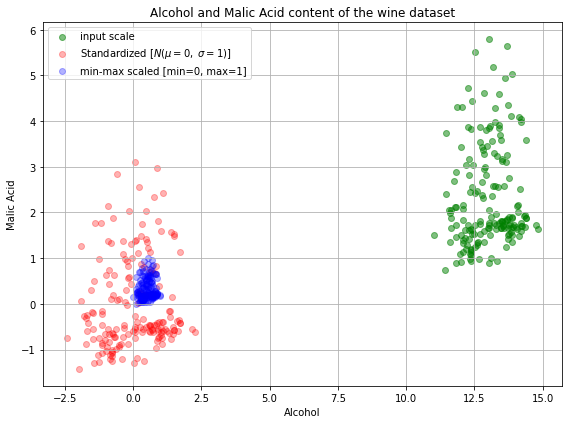

In [10]:
from matplotlib import pyplot as plt

def plot():
    plt.figure(figsize=(8,6))

    plt.scatter(df['Alcohol'], df['Malic acid'], 
            color='green', label='input scale', alpha=0.5)

    plt.scatter(df_std[:,0], df_std[:,1], color='red', 
            label='Standardized [$N  (\mu=0, \; \sigma=1)$]', alpha=0.3)

    plt.scatter(df_minmax[:,0], df_minmax[:,1], 
            color='blue', label='min-max scaled [min=0, max=1]', alpha=0.3)

    plt.title('Alcohol and Malic Acid content of the wine dataset')
    plt.xlabel('Alcohol')
    plt.ylabel('Malic Acid')
    plt.legend(loc='upper left')
    plt.grid()
    
    plt.tight_layout()

plot()
plt.show()

<br>
<br>

The plot above includes the wine datapoints on all three different scales: the input scale where the alcohol content was measured in volume-percent (green), the standardized features (red), and the normalized features (blue).
In the following plot, we will zoom in into the three different axis-scales.

<br>
<br>

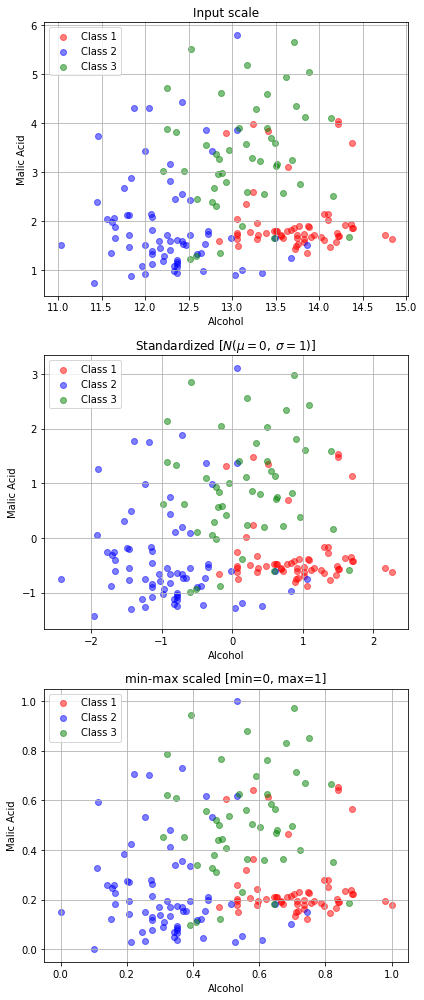

In [11]:
fig, ax = plt.subplots(3, figsize=(6,14))

for a,d,l in zip(range(len(ax)), 
               (df[['Alcohol', 'Malic acid']].values, df_std, df_minmax),
               ('Input scale', 
                'Standardized [$N  (\mu=0, \; \sigma=1)$]', 
                'min-max scaled [min=0, max=1]')
                ):
    for i,c in zip(range(1,4), ('red', 'blue', 'green')):
        ax[a].scatter(d[df['Class label'].values == i, 0], 
                  d[df['Class label'].values == i, 1],
                  alpha=0.5,
                  color=c,
                  label='Class %s' %i
                  )
    ax[a].set_title(l)
    ax[a].set_xlabel('Alcohol')
    ax[a].set_ylabel('Malic Acid')
    ax[a].legend(loc='upper left')
    ax[a].grid()
    
plt.tight_layout()

plt.show()

### Comparing features with different scales

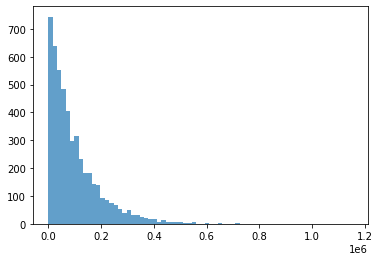

In [22]:
from scipy import stats
price_madrid = stats.gamma.rvs(1, size=5000)*100000

plt.hist(price_madrid, 70, histtype="stepfilled", alpha=.7);

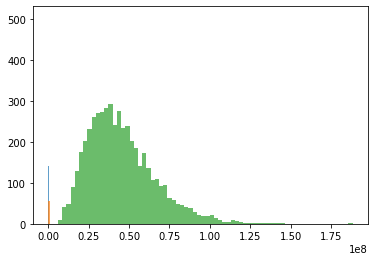

In [24]:
# Precios de casas en diferentes monedas
from scipy import stats
import matplotlib.pyplot as plt
price_madrid = stats.gamma.rvs(1, size=5000)*100000
price_london = stats.gamma(5).rvs(5000)*100000*0.87
price_spetesbourg = stats.gamma(5).rvs(5000)*100000*90.23

plt.hist(price_madrid, 70, alpha = .7)
plt.hist(price_london, 70, alpha = .7)
plt.hist(price_spetesbourg, 70, alpha = .7);

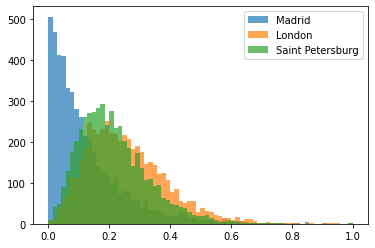

In [26]:
df = pd.DataFrame({'Madrid': price_madrid,
                  'London': price_london,
                  'Saint Petersburg': price_spetesbourg})

minmax_scale = preprocessing.MinMaxScaler().fit(df)
df_minmax = minmax_scale.transform(df)

plt.hist(df_minmax[:, 0], 70, histtype="stepfilled", alpha=.7, label='Madrid')
plt.hist(df_minmax[:, 1], 70, histtype="stepfilled", alpha=.7, label='London')
plt.hist(df_minmax[:, 2], 70, histtype="stepfilled", alpha=.7, label='Saint Petersburg')
plt.legend();

## Bottom-up approaches

Of course, we can also code the equations for standardization and 0-1 Min-Max scaling "manually". However, the scikit-learn methods are still useful if you are working with test and training data sets and want to scale them equally.

E.g., 
<pre>
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train = std_scale.transform(X_train)
X_test = std_scale.transform(X_test)
</pre>

Below, we will perform the calculations using "pure" Python code, and an more convenient NumPy solution, which is especially useful if we attempt to transform a whole matrix.

<br>
<br>

Just to recall the equations that we are using:

Standardization: \begin{equation} z = \frac{x - \mu}{\sigma} \end{equation} 

with mean:  

\begin{equation}\mu = \frac{1}{N} \sum_{i=1}^N (x_i)\end{equation}

and standard deviation:  

\begin{equation}\sigma = \sqrt{\frac{1}{N} \sum_{i=1}^N (x_i - \mu)^2}\end{equation}


Min-Max scaling: \begin{equation} X_{norm} = \frac{X - X_{min}}{X_{max}-X_{min}} \end{equation}




### Pure Python

In [27]:
# Standardization

x = [1,4,5,6,6,2,3]
mean = sum(x)/len(x)
std_dev = (1/len(x) * sum([ (x_i - mean)**2 for x_i in x]))**0.5

z_scores = [(x_i - mean)/std_dev for x_i in x]

# Min-Max scaling

minmax = [(x_i - min(x)) / (max(x) - min(x)) for x_i in x]

<br>
<br>

### NumPy

In [28]:
import numpy as np

# Standardization

x_np = np.asarray(x)
z_scores_np = (x_np - x_np.mean()) / x_np.std()

# Min-Max scaling

np_minmax = (x_np - x_np.min()) / (x_np.max() - x_np.min())

<br>
<br>

### Visualization

Just to make sure that our code works correctly, let us plot the results via matplotlib.

In [29]:
%matplotlib inline

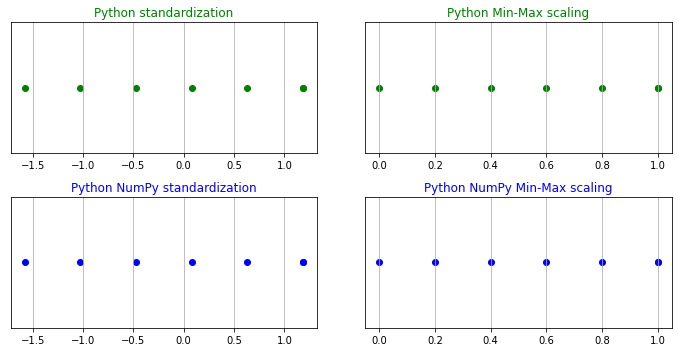

In [30]:
from matplotlib import pyplot as plt

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10,5))

y_pos = [0 for i in range(len(x))]

ax1.scatter(z_scores, y_pos, color='g')
ax1.set_title('Python standardization', color='g')

ax2.scatter(minmax, y_pos, color='g')
ax2.set_title('Python Min-Max scaling', color='g')

ax3.scatter(z_scores_np, y_pos, color='b')
ax3.set_title('Python NumPy standardization', color='b')

ax4.scatter(np_minmax, y_pos, color='b')
ax4.set_title('Python NumPy Min-Max scaling', color='b')
    
plt.tight_layout()

for ax in (ax1, ax2, ax3, ax4):
    ax.get_yaxis().set_visible(False)
    ax.grid()

plt.show()

<br>
<br>

# Binning

In [32]:
import pandas as pd

fcc_survey_df = pd.read_csv('fcc_2016_coder_survey_subset.csv', encoding='utf-8')
fcc_survey_df[['ID.x', 'EmploymentField', 'Age', 'Income']].head()

,ID.x,EmploymentField,Age,Income
0,cef35615d61b202f1dc794ef2746df14,office and administrative support,28.0,32000.0
1,323e5a113644d18185c743c241407754,food and beverage,22.0,15000.0
2,b29a1027e5cd062e654a63764157461d,finance,19.0,48000.0
3,04a11e4bcb573a1261eb0d9948d32637,"arts, entertainment, sports, or media",26.0,43000.0
4,9368291c93d5d5f5c8cdb1a575e18bec,education,20.0,6000.0


## Fixed-width binning

### Developer age distribution

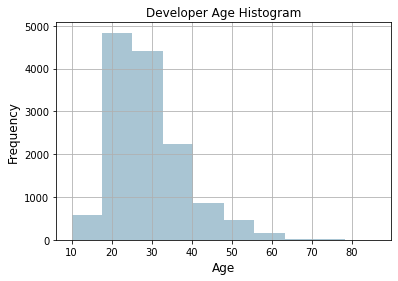

In [34]:
fig, ax = plt.subplots()
fcc_survey_df['Age'].hist(color='#A9C5D3')
ax.set_title('Developer Age Histogram', fontsize=12)
ax.set_xlabel('Age', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12);

### Binning based on rounding

``` 
Age Range: Bin
---------------
 0 -  9  : 0
10 - 19  : 1
20 - 29  : 2
30 - 39  : 3
40 - 49  : 4
50 - 59  : 5
60 - 69  : 6
  ... and so on
```

In [35]:
fcc_survey_df['Age_bin_round'] = np.array(np.floor(np.array(fcc_survey_df['Age']) / 10.))
fcc_survey_df[['ID.x', 'Age', 'Age_bin_round']].iloc[1071:1076]

,ID.x,Age,Age_bin_round
1071,6a02aa4618c99fdb3e24de522a099431,17.0,1.0
1072,f0e5e47278c5f248fe861c5f7214c07a,38.0,3.0
1073,6e14f6d0779b7e424fa3fdd9e4bd3bf9,21.0,2.0
1074,c2654c07dc929cdf3dad4d1aec4ffbb3,53.0,5.0
1075,f07449fc9339b2e57703ec7886232523,35.0,3.0


### Binning based on custom ranges

``` 
Age Range : Bin
---------------
 0 -  15  : 1
16 -  30  : 2
31 -  45  : 3
46 -  60  : 4
61 -  75  : 5
75 - 100  : 6
```

In [37]:
fcc_survey_df['Age'].unique()

array([28., 22., 19., 26., 20., 34., 23., 35., 33., 57., 47., nan, 37.,
       31., 27., 29., 30., 32., 25., 44., 21., 24., 18., 39., 41., 43.,
       36., 40., 38., 16., 46., 15., 14., 50., 49., 45., 55., 51., 17.,
       53., 52., 48., 56., 42., 54., 58., 65., 59., 75., 61., 80., 62.,
       60., 66., 12., 11., 13., 63., 64., 70., 73., 69., 71., 68., 86.,
       10., 67., 72.])

In [36]:
bin_ranges = [0, 15, 30, 45, 60, 75, 100]
bin_names = [1, 2, 3, 4, 5, 6]

fcc_survey_df['Age_bin_custom_range'] = pd.cut(np.array(fcc_survey_df['Age']), 
                                               bins=bin_ranges)
fcc_survey_df['Age_bin_custom_label'] = pd.cut(np.array(fcc_survey_df['Age']), 
                                               bins=bin_ranges, labels=bin_names)
fcc_survey_df[['ID.x', 'Age', 'Age_bin_round', 
               'Age_bin_custom_range', 'Age_bin_custom_label']].iloc[1071:1076]

,ID.x,Age,Age_bin_round,Age_bin_custom_range,Age_bin_custom_label
1071,6a02aa4618c99fdb3e24de522a099431,17.0,1.0,"(15, 30]",2
1072,f0e5e47278c5f248fe861c5f7214c07a,38.0,3.0,"(30, 45]",3
1073,6e14f6d0779b7e424fa3fdd9e4bd3bf9,21.0,2.0,"(15, 30]",2
1074,c2654c07dc929cdf3dad4d1aec4ffbb3,53.0,5.0,"(45, 60]",4
1075,f07449fc9339b2e57703ec7886232523,35.0,3.0,"(30, 45]",3


In [ ]:
def bin_ages(x):
    if x >= 0 and x <=15:
        return 1
    pass

fcc_survey_df['Age_bin_custom_label'] = fcc_survey_df['Age'].apply(bin_ages)